# Topic Modelling

In [103]:
import pandas as pd
import ast

from bertopic import BERTopic
from bertopic.representation import KeyBERTInspired
from bertopic.representation import PartOfSpeech
from bertopic.representation import MaximalMarginalRelevance
from umap import UMAP
from sentence_transformers import SentenceTransformer

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import splrep, splev

from sklearn.cluster import KMeans

## Model 1

In [104]:
df_genre = pd.read_csv('bbc_spotify.csv', index_col=0)
df_guest = pd.read_csv('Guests.csv', index_col=0)

In [105]:
# Concatenate the genres of selected discs at the guest's level
df_genre.dropna(subset=['genre'], inplace=True)
df_genre['genre'] = df_genre['genre'].astype(str)
df_genre = df_genre.groupby('links')['genre'].apply(lambda x: ' '.join(x)).reset_index()

# Merge genre data and guest data
df = df_guest.merge(df_genre, on='links', how='left')
df.dropna(subset=['genre'], inplace=True)
df

,time,duration,book,luxury,favourite,availibility,number,guests,links,index,year,genre
1,2023-05-28,35 minutes,NaN,NaN,NaN,False,0,"Ronnie O'Sullivan, snooker player",https://www.bbc.co.uk/programmes/m001mc30,1,2023,"['detroit hip hop', 'hip hop', 'rap'] ['new ro..."
2,2023-05-26,43 minutes,NaN,NaN,NaN,False,8,Desert Island Discs - Professor Sharon Peacock...,https://www.bbc.co.uk/programmes/m001m4nx,2,2023,"['folk', 'lilith', 'singer-songwriter', ""women..."
3,2023-05-19,44 minutes,NaN,NaN,NaN,False,8,"Simon Pegg, actor",https://www.bbc.co.uk/programmes/m001ly7j,3,2023,"['beatlesque', 'british invasion', 'classic ro..."
4,2023-05-12,37 minutes,NaN,NaN,NaN,False,8,"Professor Peter Hennessy, historian",https://www.bbc.co.uk/programmes/m001lr3k,4,2023,"[] ['baroque', 'classical', 'early music', 'ge..."
5,2023-03-31,43 minutes,NaN,NaN,NaN,True,9,"Dara Ó Briain, comedian and television presenter",https://www.bbc.co.uk/programmes/m001kgn0,5,2023,"['funk', 'funk rock', 'minneapolis sound', 'ro..."
...,...,...,...,...,...,...,...,...,...,...,...,...
3354,1942-03-05,30 minutes,NaN,NaN,NaN,False,8,Jack Hylton,https://www.bbc.co.uk/programmes/p009y0n5,3354,1942,"['classical', 'classical drill', 'late romanti..."
3355,1942-02-26,30 minutes,NaN,NaN,NaN,False,7,Pat Kirkwood,https://www.bbc.co.uk/programmes/p009y0n8,3355,1942,"['drama', 'hollywood', 'vintage broadway'] ['m..."
3356,1942-02-19,30 minutes,NaN,NaN,NaN,False,8,C B Cochran,https://www.bbc.co.uk/programmes/p009y0nd,3356,1942,"['ccm'] ['french opera', 'operetta'] ['early m..."
3357,1942-02-12,30 minutes,NaN,NaN,NaN,False,8,Commander Campbell,https://www.bbc.co.uk/programmes/p009y0nh,3357,1942,"[] ['music hall'] ['british modern classical',..."


Establish the model

In [106]:
docs = df['genre']

representation_models = {
    "Main": KeyBERTInspired(),
    "Aspect1": PartOfSpeech("en_core_web_sm"),
    "Aspect2": [KeyBERTInspired(top_n_words=30),\
    MaximalMarginalRelevance(diversity=0.5)],
    "Aspect3": MaximalMarginalRelevance(diversity=0.5)
}

topic_model1 = BERTopic(
    nr_topics="auto",
    n_gram_range=(1,2),
    umap_model=UMAP(n_neighbors=40, metric='cosine', low_memory=False),
    representation_model=representation_models
)

topics, probs = topic_model1.fit_transform(docs)

In [107]:
embedding_model = "sentence-transformers/all-MiniLM-L6-v2"
topic_model1.save("Model1", serialization="safetensors", save_ctfidf=True, save_embedding_model=embedding_model)
# topic_model1 = BERTopic.load("Model1")

In [108]:
topic_model1.get_topic_info()

,Topic,Count,Name,Representation,Aspect1,Aspect2,Aspect3,Representative_Docs
0,-1,1535,-1_romanticism classical_baroque classical_cla...,"[romanticism classical, baroque classical, cla...","[classical, era, rock, early, romantic, romant...","[romanticism classical, german baroque, italia...","[romanticism classical, baroque classical, cla...","[['baroque', 'classical', 'early music', 'engl..."
1,0,1052,0_baroque classical_romanticism classical_mode...,"[baroque classical, romanticism classical, mod...","[classical, era, romantic era, romanticism, ro...","[romanticism classical, german baroque, classi...","[baroque classical, romanticism classical, mod...","[['baroque', 'classical', 'early music', 'germ..."
2,1,146,1_rock blues_blues rock_rock symphonic_rock me...,"[rock blues, blues rock, rock symphonic, rock ...","[rock, classic, classic rock, mellow, gold, me...","[rock blues, rock mellow, symphonic rock, psyc...","[rock blues, blues rock, rock symphonic, rock ...","[['album rock', 'classic rock', 'hard rock', '..."
3,2,100,2_indie rock_pop rock_alternative rock_dance rock,"[indie rock, pop rock, alternative rock, dance...","[rock, wave, new, new wave, pop, permanent wav...","[pop rock, alternative rock, dance rock, wave ...","[indie rock, pop rock, alternative rock, dance...","[['art rock', 'classic rock', 'glam rock', 'pe..."
4,3,91,3_jazz adult_adult standards_listening adult_l...,"[jazz adult, adult standards, listening adult,...","[standards, adult, easy, lounge, vintage, voca...","[jazz adult, adult standards, listening adult,...","[jazz adult, adult standards, listening adult,...","[['british dance band', 'music hall', 'operett..."
5,4,87,4_soul jazz_jazz blues_renaissance jazz_vocal ...,"[soul jazz, jazz blues, renaissance jazz, voca...","[jazz, soul, blues, vocal, vocal jazz, rock, c...","[soul jazz, jazz blues, renaissance jazz, voca...","[soul jazz, jazz blues, renaissance jazz, voca...","[['bebop', 'contemporary post-bop', 'cool jazz..."
6,5,87,5_vocal jazz_renaissance jazz_jazz jazz_vintag...,"[vocal jazz, renaissance jazz, jazz jazz, vint...","[jazz, vocal jazz, vocal, dixieland, renaissan...","[renaissance jazz, jazz vocal, jazz africaname...","[vocal jazz, renaissance jazz, jazz jazz, vint...","[['african-american classical', 'harlem renais..."
7,6,50,6_band classical_dance band_orchestra vintage_...,"[band classical, dance band, orchestra vintage...","[band, british dance, british, dance, hall, mu...","[band classical, dance band, hall classical, b...","[band classical, dance band, orchestra vintage...",[['bagpipe marching band'] [] ['british dance ...
8,7,48,7_rock folk_folk rock_alternative rock_rock me...,"[rock folk, folk rock, alternative rock, rock ...","[rock, folk, country, classic, classic rock, m...","[folk rock, alternative rock, rock mellow, cou...","[rock folk, folk rock, alternative rock, rock ...","[['classic rock', 'country rock', 'folk', 'fol..."
9,8,47,8_piano rock_rock mellow_rock rock_art rock,"[piano rock, rock mellow, rock rock, art rock,...","[rock, pop, hop, hip, classic, soft rock, soft...","[piano rock, rock mellow, classic rock, rock b...","[piano rock, rock mellow, rock rock, art rock,...","[['adult standards', 'torch song', 'vocal jazz..."


In [109]:
topic_model1.reduce_topics(docs, nr_topics=9)

In [110]:
topic_model1.visualize_barchart()

In [111]:
model = topic_model1.get_document_info(docs)
df_update = df.merge(model[['Document','Topic']], left_on='genre', right_on='Document')

In [112]:
def plot_trend(df):
  set1 = df.groupby('year').size().reset_index(name='count')
  set2 = df.groupby(['year','Topic']).size().reset_index(name='count')
  final = pd.merge(set2, set1, how='left', on='year')
  final['prop']= final['count_x'] / final['count_y']
  final = final[(final['Topic'] != -1) & (final['year'] > 1949) & (final['year'] < 2023)]

  # Get unique topic labels
  unique_labels = final['Topic'].unique()
  # Set up color palette for the unique labels
  color_palette = sns.color_palette('Set1', len(unique_labels))
  # Plot
  plt.figure(figsize=(13, 3))
  for i, label in enumerate(unique_labels):
      data = final[final['Topic'] == label]
      plt.plot(data['year'], data['prop'], label=label, color=color_palette[i])

  plt.xlabel('Year')
  plt.ylabel('Proportion')
  plt.title('How the proportion of different topics change over time')
  plt.grid(True)
  plt.legend()
  plt.show()

  plt.figure(figsize=(13, 3))

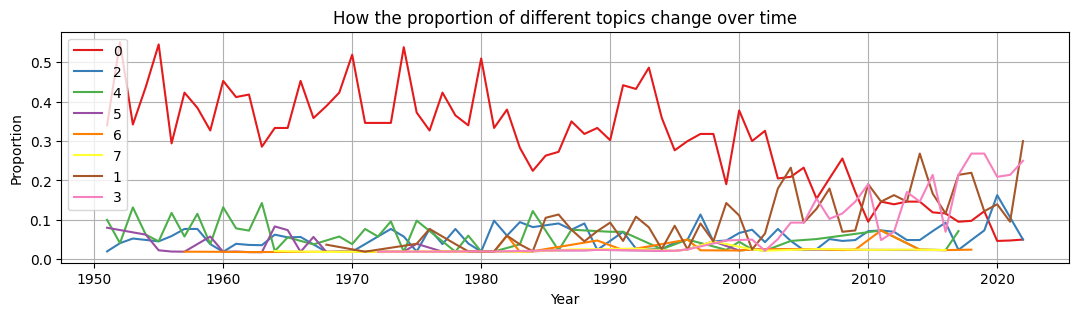

<Figure size 1300x300 with 0 Axes>

In [113]:
plot_trend(df_update)

## Model 2

In [137]:
df_genre2 = pd.read_csv('bbc_spotify.csv', index_col=0)

In [138]:
# Exract the main genre of a song
def extract_main_genre(line):
    try:
        genres = ast.literal_eval(line)
        if isinstance(genres, list) and len(genres) > 0:
            return genres[0]
        else:
            return None
    except:
        return None

df_genre2['main_genre'] = df_genre2['genre'].apply(extract_main_genre)


In [139]:
# Concatenate the genres of selected discs at the guest's level
df_genre2.dropna(subset=['main_genre'], inplace=True)
df_genre2['main_genre'] = df_genre2['main_genre'].astype(str)
df_genre2 = df_genre2.groupby('links')['main_genre'].apply(lambda x: ' '.join(x)).reset_index()
df_genre2



,links,main_genre
0,https://www.bbc.co.uk/programmes/b00772lv,baroque classical classical classical classica...
1,https://www.bbc.co.uk/programmes/b00773ry,drama beatlesque classical art rock adult stan...
2,https://www.bbc.co.uk/programmes/b007742c,baroque pop southern soul beatlesque classic r...
3,https://www.bbc.co.uk/programmes/b00774c4,boy band classic soundtrack adult standards po...
4,https://www.bbc.co.uk/programmes/b00774n5,classic rock album rock cool jazz british mode...
...,...,...
3346,https://www.bbc.co.uk/programmes/p009ycz0,classic oklahoma country adult standards music...
3347,https://www.bbc.co.uk/programmes/p009ycz4,cabaret german opera vintage classical singing...
3348,https://www.bbc.co.uk/programmes/p00d9yb6,tin pan alley big band adult standards adult s...
3349,https://www.bbc.co.uk/programmes/p00f9p83,adult standards beatlesque experimental classi...


In [140]:
# Merge genre data and guest data
df2 = df_guest.merge(df_genre2, on='links', how='left')
df2.dropna(subset=['main_genre'], inplace=True)
df2

,time,duration,book,luxury,favourite,availibility,number,guests,links,index,year,main_genre
1,2023-05-28,35 minutes,NaN,NaN,NaN,False,0,"Ronnie O'Sullivan, snooker player",https://www.bbc.co.uk/programmes/m001mc30,1,2023,detroit hip hop new romantic dance pop new rom...
2,2023-05-26,43 minutes,NaN,NaN,NaN,False,8,Desert Island Discs - Professor Sharon Peacock...,https://www.bbc.co.uk/programmes/m001m4nx,2,2023,folk british choir british folk soft rock mode...
3,2023-05-19,44 minutes,NaN,NaN,NaN,False,8,"Simon Pegg, actor",https://www.bbc.co.uk/programmes/m001ly7j,3,2023,beatlesque album rock british orchestra madche...
4,2023-05-12,37 minutes,NaN,NaN,NaN,False,8,"Professor Peter Hennessy, historian",https://www.bbc.co.uk/programmes/m001lr3k,4,2023,baroque british comedy classical comic alterna...
5,2023-03-31,43 minutes,NaN,NaN,NaN,True,9,"Dara Ó Briain, comedian and television presenter",https://www.bbc.co.uk/programmes/m001kgn0,5,2023,funk dub classical hip house new wave pop hamm...
...,...,...,...,...,...,...,...,...,...,...,...,...
3354,1942-03-05,30 minutes,NaN,NaN,NaN,False,8,Jack Hylton,https://www.bbc.co.uk/programmes/p009y0n5,3354,1942,classical british dance band british dance ban...
3355,1942-02-26,30 minutes,NaN,NaN,NaN,False,7,Pat Kirkwood,https://www.bbc.co.uk/programmes/p009y0n8,3355,1942,drama music hall classical british dance band ...
3356,1942-02-19,30 minutes,NaN,NaN,NaN,False,8,C B Cochran,https://www.bbc.co.uk/programmes/p009y0nd,3356,1942,ccm french opera early modern classical classi...
3357,1942-02-12,30 minutes,NaN,NaN,NaN,False,8,Commander Campbell,https://www.bbc.co.uk/programmes/p009y0nh,3357,1942,music hall british modern classical classical ...


In [141]:
docs = df2['main_genre']

representation_models = {
    "Main": KeyBERTInspired(),
    "Aspect1": PartOfSpeech("en_core_web_sm"),
    "Aspect2": [KeyBERTInspired(top_n_words=30),\
    MaximalMarginalRelevance(diversity=0.5)],
    "Aspect3": MaximalMarginalRelevance(diversity=0.5)
}

topic_model2 = BERTopic(
    nr_topics="auto",
    umap_model = UMAP(n_neighbors=15, metric='cosine', low_memory=False),
    # hdbscan_model=KMeans(n_clusters=30),
    representation_model=representation_models
)

topics, probs = topic_model2.fit_transform(docs)

In [142]:
embedding_model = "sentence-transformers/all-MiniLM-L6-v2"
topic_model2.save("Model2", serialization="safetensors", save_ctfidf=True, save_embedding_model=embedding_model)
# topic_model = BERTopic.load("Model2")

In [143]:
topic_model2.get_topic_info()

,Topic,Count,Name,Representation,Aspect1,Aspect2,Aspect3,Representative_Docs
0,-1,988,-1_classical_baroque_standards_adult,"[classical, baroque, standards, adult, orchest...","[standards, adult, rock, classic, pop, classic...","[baroque, standards, adult, piano, tenor, orch...","[classical, baroque, standards, adult, orchest...",[adult standards adult standards baroque ameri...
1,0,719,0_classical_baroque_modernism_renaissance,"[classical, baroque, modernism, renaissance, c...","[classical, baroque, modern, british, era, roc...","[classical, baroque, contemporary, opera, aust...","[classical, baroque, modernism, renaissance, c...",[classical baroque classical classical classic...
2,1,704,1_standards_classical_operatic_dance,"[standards, classical, operatic, dance, orches...","[standards, adult, band, dance, british, class...","[standards, operatic, orchestra, tenor, cabare...","[standards, classical, operatic, dance, orches...",[british dance band classical adult standards ...
3,2,153,2_rock_rockandroll_funk_afrobeat,"[rock, rockandroll, funk, afrobeat, afrobeats,...","[rock, alternative, album, soul, pop, hip, cla...","[rockandroll, funk, afrobeats, indie, drums, b...","[rock, rockandroll, funk, afrobeat, afrobeats,...",[album rock funk classic rock album rock class...
4,3,91,3_liturgy_baroque_classical_anglican,"[liturgy, baroque, classical, anglican, gregor...","[liturgy, anglican, classical, british, modern...","[liturgy, baroque, gregorian, orchestra, conte...","[liturgy, baroque, classical, anglican, gregor...",[classical anglican liturgy british modern cla...
5,4,88,4_classical_folk_revival_baroque,"[classical, folk, revival, baroque, traditiona...","[revival, folk, american, baroque, classical, ...","[folk, revival, baroque, traditional, victoria...","[classical, folk, revival, baroque, traditiona...",[classical classical american folk revival cla...
6,5,73,5_classical_torch_baroque_operatic,"[classical, torch, baroque, operatic, orchestr...","[torch, song, adult, standards, music, hall, c...","[torch, baroque, clarinet, victorian, jazz, op...","[classical, torch, baroque, operatic, orchestr...",[classical british dance band classical torch ...
7,6,71,6_classical_chanson_baroque_orchestral,"[classical, chanson, baroque, orchestral, oper...","[chanson, vintage, classical, baroque, modern,...","[chanson, baroque, orchestral, opera, tenor, f...","[classical, chanson, baroque, orchestral, oper...","[chanson chanson chanson chanson classical, cl..."
8,7,68,7_classical_baroque_poetry_contemporary,"[classical, baroque, poetry, contemporary, ope...","[poetry, classical, baroque, era, modern, brit...","[baroque, poetry, opera, vaudeville, contralto...","[classical, baroque, poetry, contemporary, ope...",[classical baroque classical classical classic...
9,8,46,8_cabaret_classical_baroque_orchestral,"[cabaret, classical, baroque, orchestral, orch...","[cabaret, classical, german, vintage, opera, b...","[cabaret, baroque, orchestra, harpsichord, sop...","[cabaret, classical, baroque, orchestral, orch...",[classical classical classical cabaret classic...


In [144]:
topic_model2.reduce_topics(docs, nr_topics=9)

In [146]:
topic_model2.visualize_barchart()

In [147]:
model = topic_model2.get_document_info(docs)
df2_update = df2.merge(model[['Document','Topic']], left_on='main_genre', right_on='Document')

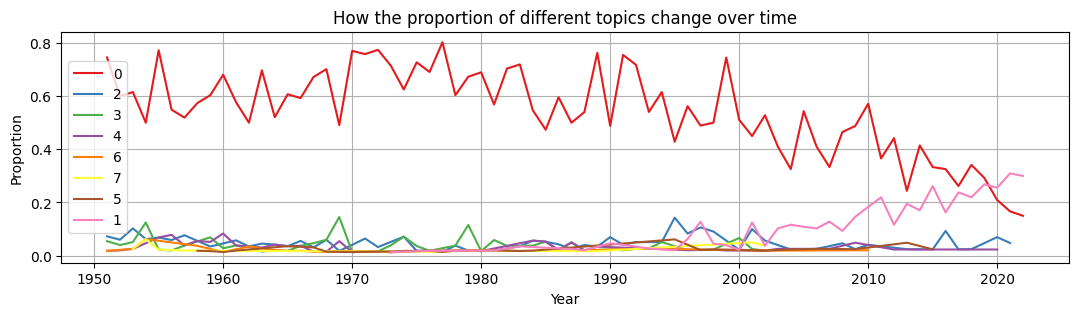

<Figure size 1300x300 with 0 Axes>

In [148]:
plot_trend(df2_update)

## Model 3

In [150]:
# Prepare embeddings
docs = df['genre'].tolist()
sentence_model = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = sentence_model.encode(docs, show_progress_bar=False)

# Train the topic model using the pre-trained sentence-transformers embeddings
topic_model3 = BERTopic(
    nr_topics="auto",
    n_gram_range=(1,2),
    umap_model = UMAP(n_neighbors=40, metric='cosine', low_memory=False),
    representation_model=sentence_model
)

topics, probs = topic_model3.fit_transform(docs, embeddings)

In [151]:
embedding_model = "sentence-transformers/all-MiniLM-L6-v2"
topic_model3.save("Model3", serialization="safetensors", save_ctfidf=True, save_embedding_model=embedding_model)
# topic_model3 = BERTopic.load("Model3")

In [155]:
topic_model3.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,1443,-1_classical_era_rock_jazz,"[classical, era, rock, jazz, early, baroque, r...",NaN
1,0,1364,0_classical_era_romantic era_romantic,"[classical, era, romantic era, romantic, early...",NaN
2,1,225,1_rock_soul_classic_folk,"[rock, soul, classic, folk, blues, jazz, singe...",NaN
3,2,106,2_standards_adult standards_adult_listening,"[standards, adult standards, adult, listening,...",NaN
4,3,84,3_jazz_swing_jazz jazz_vocal jazz,"[jazz, swing, jazz jazz, vocal jazz, vocal, di...",NaN
5,4,56,4_rock_wave_permanent wave_permanent,"[rock, wave, permanent wave, permanent, new, n...",NaN
6,5,45,5_blues_jazz_classical_soul,"[blues, jazz, classical, soul, rock, baroque, ...",NaN
7,6,28,6_hop_hip_hip hop_pop,"[hop, hip, hip hop, pop, rock, wave, new, rap,...",NaN


In [157]:
topic_model3.visualize_barchart()

In [159]:
model = topic_model3.get_document_info(docs)
df3_update = df.merge(model[['Document','Topic']], left_on='genre', right_on='Document')

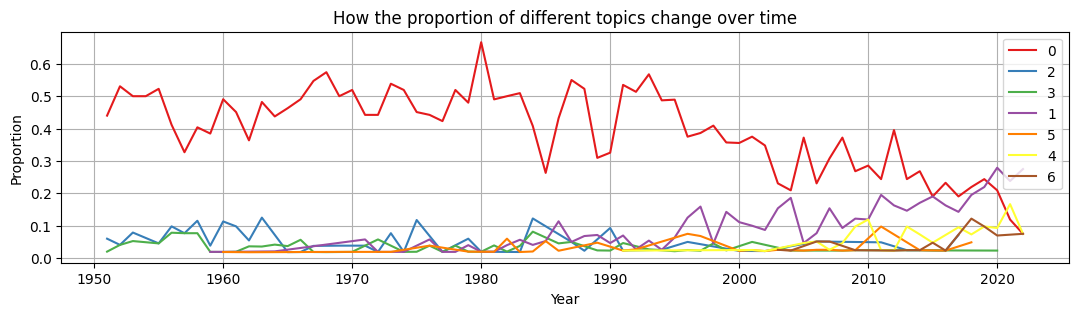

<Figure size 1300x300 with 0 Axes>

In [160]:
plot_trend(df3_update)